# k-Nearest Neighbors

<hr style="clear:both">

This notebook is part of a series of exercises for the CIVIL-226 Introduction to Machine Learning for Engineers course at EPFL. Copyright (c) 2021 [VITA](https://www.epfl.ch/labs/vita/) lab at EPFL  
Use of this source code is governed by an MIT-style license that can be found in the LICENSE file or at https://www.opensource.org/licenses/MIT

**Author(s):** [David Mizrahi](mailto:david.mizrahi@epfl.ch)
<hr style="clear:both">

In this exercise, you will implement a k-Nearest Neighbors (k-NN) classifier and see how to use a validation set to find optimal hyper-parameters.

The `### START CODE HERE ###` and `### END CODE HERE ###` comments in code cells indicate where you should write code.


In [1]:
# Function to align all tables to the left (useful for later on)

In [1]:
%%html
<style>
table {float:left}
</style>

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Any, Callable

# Helper file with functions for pre-processing and visualization
import helpers

## 0. Intro

*Background: You and your friends went on an expedition to the Antarctic, where you befriended a group of penguins. After taking a few measurements, you went back home. You're now wondering if it is possible to classify the penguins you befriended by building a classifier.*

To build such a classifier, you will need some labeled data. Luckily for you, the Palmer Penguins dataset contains exactly the data you need.

You decide to implement a kNN classifier. As a reminder, it works in the following way: For an unknown data point, find the k nearest neighbors from a labeled dataset, and return the majority vote (most frequent class) of these neighbors.

![penguins](images/penguins.jpg)

## 1. Data loading & pre-processing

In this exercise, you will use the [Palmer Penguins dataset](https://github.com/allisonhorst/palmerpenguins) and your goal is to classify 3 species of Penguins: Adélie, Chinstrap and Gentoo.

Let's load the dataset using the [pandas](https://pandas.pydata.org/) library. Don't worry, there's no need to know how to use this library for this exercise.

In [5]:
# In Pandas, a data table is called a DataFrame (abbreviated to df)
labeled_df = pd.read_csv('data/labeled_penguins.csv')

print(f"There are {labeled_df.shape[0]} rows and {labeled_df.shape[1]} columns.")
# Show the first 5 rows of the data
labeled_df.head(5)

There are 204 rows and 3 columns.


,species,bill_length_mm,body_mass_g
0,Chinstrap,54.2,4300.0
1,Gentoo,50.0,5700.0
2,Adelie,39.6,3900.0
3,Gentoo,45.7,4400.0
4,Gentoo,46.5,4550.0


Now, we'll use the function `preprocess_data()` from `helpers.py` to shuffle the data, convert the labels to integers, split it into a training, validation and test set, and then return the result as NumPy arrays.
Feel free to read the code in `helpers.py` to better understand what this function does (completely optional).

In [6]:
# We'll use 60% of our data as training data, 20% for our validation data and the remaining 20% as test data
# Here, we use a random seed to ensure that the data shuffling and splitting can be reproduced
X_train, y_train, X_val, y_val, X_test, y_test, feature_names, label_map = helpers.preprocess_data(df=labeled_df, label="species", train_size=0.6, val_size=0.2, seed=42)


Run the following cells to better understand how the preprocessed data looks like.

In [7]:
print(f"Features: {feature_names}")
print(f"Map from label to label name: {label_map}")

Features: ['bill_length_mm', 'body_mass_g']
Map from label to label name: {0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}


In [8]:
# Visualisation of X_train and y_train (separation of the features and the labels)
print('Training set features (first 10 samples):')
print(f'X_train: \n {X_train[:10]}')

print('\nTraining set labels (first 10 samples):')
print(f'y_train: \n {y_train[:10]}')

Training set features (first 10 samples):
X_train: 
 [[  39.2 4675. ]
 [  42.1 4000. ]
 [  46.  4150. ]
 [  49.8 3675. ]
 [  39.6 3900. ]
 [  41.5 4000. ]
 [  46.6 3800. ]
 [  45.1 5050. ]
 [  43.3 4400. ]
 [  48.8 6000. ]]

Training set labels (first 10 samples):
y_train: 
 [0 0 1 1 0 0 1 2 2 2]


In [9]:
# Show shapes
print('Training set shape:')
print(f'X: {X_train.shape}, y: {y_train.shape}')

print('\nValidation set shape:')
print(f'X: {X_val.shape}, y: {y_val.shape}')

print('\nTest set shape:')
print(f'X: {X_test.shape}, y: {y_test.shape}')

Training set shape:
X: (122, 2), y: (122,)

Validation set shape:
X: (41, 2), y: (41,)

Test set shape:
X: (41, 2), y: (41,)


Let's also load our unlabeled measurements of penguins. This is the data we want to classify.

In [10]:
unlabeled_df = pd.read_csv('data/unlabeled_penguins.csv')

print(f"There are {unlabeled_df.shape[0]} rows and {unlabeled_df.shape[1]} columns.")
# Show the first 5 rows of the data
unlabeled_df.head(5)

There are 50 rows and 2 columns.


,bill_length_mm,body_mass_g
0,45.9,3500.0
1,47.8,3900.0
2,53.8,4200.0
3,48.2,3500.0
4,45.5,4000.0


In [11]:
# Convert this unlabeled data to a matrix
X_unlabeled = unlabeled_df.to_numpy()

print('Unlabeled dataset shape:')
print(f'X: {X_unlabeled.shape}')

Unlabeled dataset shape:
X: (50, 2)


To summarize, we have an unlabeled dataset of penguins (`X_unlabeled`) that we want to classify. 

We made the assumption that the labeled Palmer Penguins dataset comes from a similar distribution, so we decided to use it for our  classifier. We then split this dataset into a training set (`X_train`, `y_train`), a validation set (`X_val`, `y_val`) and a test set (`X_test`, `y_test`).

## 2. Data visualization & scaling

Let's take a look at our data using the `plot_labeled()` and `plot_unlabeled()` functions of `helpers.py`.

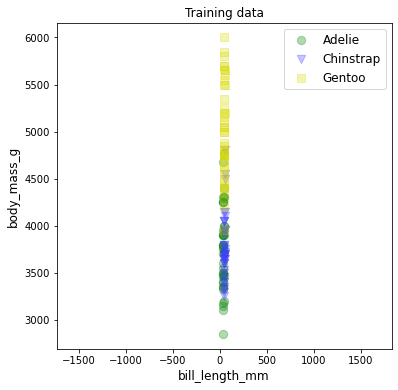

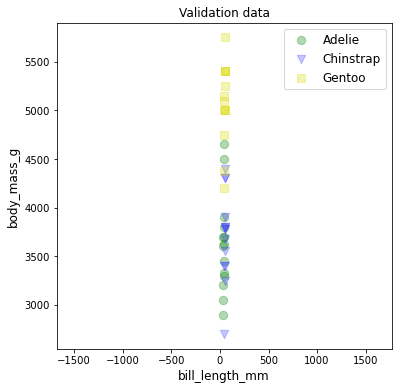

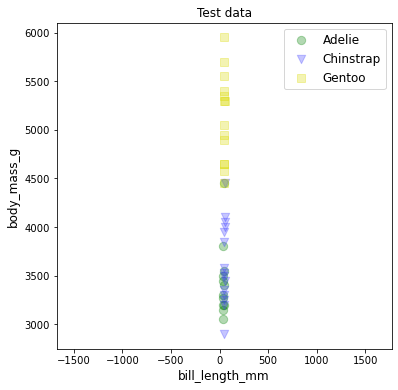

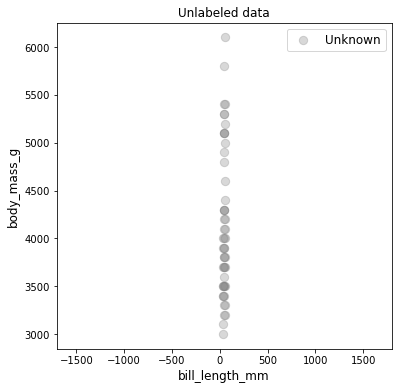

In [12]:
# Plot training data with labels
helpers.plot_labeled(X_train, y_train, label_map, feature_names, title="Training data")
# Plot validation data with labels
helpers.plot_labeled(X_val, y_val, label_map, feature_names, title="Validation data")
# Plot test data with labels
helpers.plot_labeled(X_test, y_test, label_map, feature_names, title="Test data")
# Plot unlabeled data
helpers.plot_unlabeled(X_unlabeled, feature_names, title="Unlabeled data")

**Question:** What do you notice? How will this affect the kNN classifier?

**Answer:** They all have a similar bill length, The kNN classifier will only consist of a serparation in body mass (closest neighbour in just one axis) 

As features can represent different physical units and come in vastly different scales, it is common practice to normalize the  data before using kNN.

Here, we'll use Z-score standardization.  That is, for each feature, compute: $x_{norm} = \frac {x - \mu_x} {\sigma_x}$

Let's implement the function `normalize()`:

**Note:** Remember that you should not use any of the knowledge you get from the test data when implementing a model. This includes the normalization step, where you should use the mean and standard deviation of the **training set** to normalize all the other datasets.

In [13]:
# Compute the mean and standard deviation for each feature of the training set

### START CODE HERE ### (≈ 2 lines of code)
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
### END CODE HERE ###


# Implement the normalize function
def normalize(X: np.ndarray, mean: np.ndarray, std: np.ndarray):
    """ Normalization of array using Z-score standardization
     Args:
        X: Dataset of shape (N, D)
        mean: Mean of shape (D, )
        std: Standard deviation of shape(D, )
    """
    ### START CODE HERE ### (≈ 1 line of code)
    X_normalized = (X-mean)/std
    ### END CODE HERE ###
    return X_normalized

# Normalize features of the training, val and test set using the mean and std of the training set features
X_train = normalize(X_train, mean, std)
X_val = normalize(X_val, mean, std)
X_test = normalize(X_test, mean, std)
X_unlabeled = normalize(X_unlabeled, mean, std)

# Let's rename the features to indicate that they've been normalized
feature_names = ['Bill length (normalized)', 'Body mass (normalized)']

In [14]:
# Verify that normalization is implemented correctly 
# We check that the mean and std of each feature of the training set is very close to 0 and 1 respectively
if (np.allclose(X_train.mean(axis=0), np.zeros_like(X_train)) and (np.allclose(X_train.std(axis=0), np.ones_like(X_train)))):
    print("All good my bg!<3")
else:
    print("normalize() doesn't work correctly :(")

All good my bg!<3


Now that the data is normalized, let's plot it again, using the same functions from `helpers` as before.

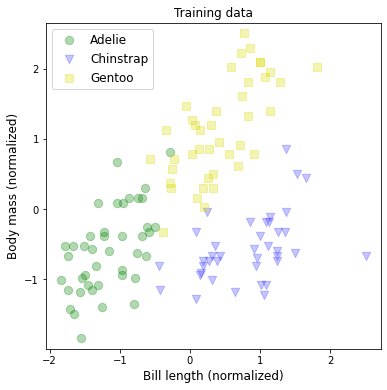

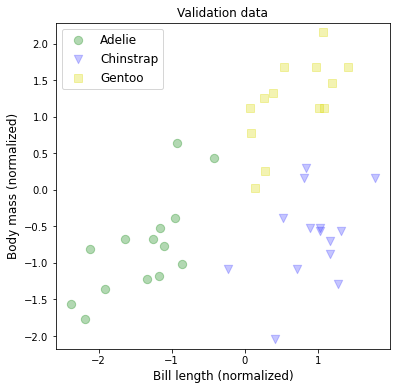

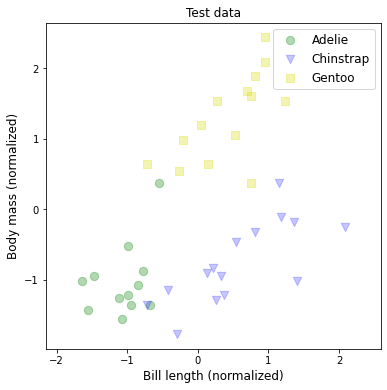

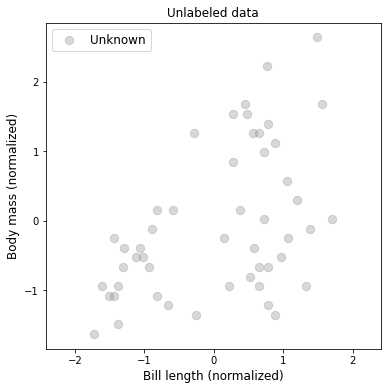

In [15]:
# Plot normalized training data with labeled, and normalized test data without labels

### START CODE HERE ### (≈ 4 lines of code)
helpers.plot_labeled(X_train, y_train, label_map, feature_names, title="Training data")
helpers.plot_labeled(X_val, y_val, label_map, feature_names, title="Validation data")
helpers.plot_labeled(X_test, y_test, label_map, feature_names, title="Test data")
helpers.plot_unlabeled(X_unlabeled, feature_names, title="Unlabeled data")
### END CODE HERE ###

Wow, this is much better! Now that the data is normalized, we can implement our classifier.

## 3. Distance metrics

In this part, we'll work on the distance metrics used by the classifier. We have seen two distance metrics:

**The L1 (Manhattan) distance:**

$$
d(\mathbf{p}, \mathbf{q})=\sum_{i=1}^{n} | p_{i}-q_{i} |
$$

It is also sometimes known as city block or taxicab distance, in allusion to the fact that the shortest path by car in a city with a grid layout (such as Manhattan) would result in this distance.

**The L2 (Euclidean) distance:**

$$
d(\mathbf{p}, \mathbf{q})=\sqrt{\sum_{i=1}^{n}\left(p_{i}-q_{i}\right)^{2}}
$$

This is the distance with which you are probably most familar with, it can be seen as the straight line distance between two points.

![distances](images/manhattan_euclidean.png)


Let's implement functions that compute the distance between a single vector to all vectors of the training data. Until the end of this exercise, we define "sample" as a single entry of the dataset. The entry is a vector of D attributes, and the code should stay flexible for any number of attributes.

**Hint:** NumPy's [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) is your friend.

In [16]:
def manhattan_dist(sample: np.ndarray, X: np.ndarray):
    """Computes the Manhattan distance between a sample and the training features

    Args:
        sample: Sample of shape (D, )
        X: Dataset of shape (N, D)

    Returns:
        dist: Distances of shape (N,)

    """
    ### START CODE HERE ### (≈ 1 line of code)
    distances = np.abs(X - sample).sum(axis=1) 
    #diff pour chaque exemple
    
    ### END CODE HERE ### 
    return distances
   
    
def euclidean_dist(sample: np.ndarray, X: np.ndarray):
    """Computes the Euclidean distance between a sample and the training features

    Args:
        sample: Sample of shape (D, )
        X: Dataset of shape (N, D)

    Returns:
        dist: Distances of shape (N,)

    """
    ### START CODE HERE ### (≈ 1 line of code)
    distances = np.sqrt(((X-sample)**2).sum(axis=1))
    ### END CODE HERE ### 
    return distances
   

In [17]:
# Verify implementation
print(f'Manhattan: {np.round(manhattan_dist(X_val[0], X_train[:3]), decimals=1)}')
print(f'Euclidean: {np.round(euclidean_dist(X_val[0], X_train[:3]), decimals=1)}')


Manhattan: [4.2 2.7 2.2]
Euclidean: [3.1 2.  2. ]


**Expected output:**  

|   |                                                  |
|---|--------------------------------------------------|
| **Manhattan** | [4.2 2.7 2.2] |
| **Euclidean** | [3.1 2.  2. ] |

## 4. Finding neighbors

It's time to find the nearest neighbors.
Implement `find_nearest_neighbors()` according to its documentation.

**Hint:** [`np.argsort()`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) is a very useful function when working with indices.

In [18]:
essai = [3, 1, 2]
np.argsort(essai)

array([1, 2, 0])

In [19]:
def find_nearest_neighbors(
    sample: np.ndarray, 
    X: np.ndarray, 
    distance_fn: Callable = euclidean_dist, 
    k: int = 1):
    """Finds the indices of the k-Nearest Neighbors to a sample
    Args:
        sample: Sample of shape (D, )
        X: Dataset of shape (N, D)
        distance_fn: Distance function
        k: Number of nearest neighbors

    Returns:
        indices: Neighbor indices of shape (k, )
    """
    ### START CODE HERE ### (≈ 2 lines of code)
    neighbor_indices = (np.argsort(euclidean_dist(sample,X)))[:k]
    
    print(neighbor_indices)
    ### END CODE HERE ###
    
    return neighbor_indices

[66 22 80 89 10]


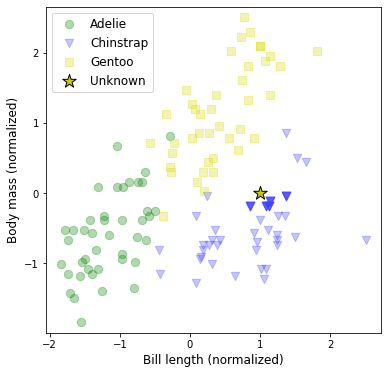

In [20]:
# Try changing the sample position, distance function and value of k
# Does your find_nearest_neighbors() implementation seem correct?
sample = np.array([1, 0])
distance_fn = euclidean_dist
k = 5

# Plot the nearest neighbors using helpers.py
neighbor_indices = find_nearest_neighbors(sample, X_train, distance_fn=distance_fn, k=k)
helpers.plot_nearest_neighbors(sample, X_train, y_train, neighbor_indices, label_map, feature_names)

The opaque points correspond to the nearest neighbors to the unknown point (star).

Now that you have a function that finds the nearest neighbor, let's implement the function `predict_single()` which returns the majority class of the k-nearest neighbors of a given sample. Do not worry about tie-breakers (i.e. if multiple classes have as many points in proximity to a sample).

**Hints:**
- Feel free to reuse functions you implemented previously
- Labels are numbered from 0 to n-1 (with n the number of classes) 
- [`np.bincount()`](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html) and [`np.argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) can be very useful.

In [23]:
def predict_single(
    sample: np.ndarray, 
    X: np.ndarray, 
    y: np.ndarray, 
    distance_fn: Callable, 
    k: int = 1):
    """ Finds the k-Nearest Neighbors to a sample and returns the majority class
    Args:
        sample: Sample of shape (D, )
        X: Dataset of shape (N, D)
        y: Labels of shape (N, )
        distance_fn: Distance function
        k: number of nearest neighbors

    Returns:
        label: Predicted label, the majority class of the k-Nearest Neighbors

    """
    
    ### START CODE HERE ### (≈ 4 lines of code)
    indices = find_nearest_neighbors(sample, X, distance_fn, k)
    labels = []
    for i in indices:
        labels+= [y[i]]
    counts = np.bincount(labels)
    predicted_label = np.argmax(counts)
    
    ### END CODE HERE ### 
   
    return predicted_label

Now, we can reuse `predict_single()` to predict several samples at once. 

**Hint:** There are several ways to do this, such as using a simple for-loop or with the function [`np.apply_along_axis()`](https://numpy.org/doc/stable/reference/generated/numpy.apply_along_axis.html)

In [35]:
# With for-loop
def predict(
    samples: np.ndarray, 
    X: np.ndarray = X_train, 
    y: np.ndarray = y_train, 
    distance_fn: Callable = euclidean_dist, 
    k: int = 1):
    """ Finds the k-Nearest Neighbors to a matrix of samples and returns 
        the majority class for each of these samples as an array
    Args:
        samples: Samples of shape (M, D)
        X: Dataset of shape (N, D)
        y: Labels of shape (N, )
        distance_fn: Distance function
        k: number of nearest neighbors

    Returns:
        labels: Predicted labels of shape (M, )

    """
    ### START CODE HERE ### (≈ 1 to 5 lines of code depending on the implementation)
    predicted_labels = np.apply_along_axis(predict_single, axis=1, arr=samples,
                                           X=X, y=y, distance_fn=distance_fn, k=k)
    ### END CODE HERE ###
    
    return predicted_labels

In [36]:
# Verify implementation
print(f'Predicted labels: {predict(X_val[:6], X_train, y_train, euclidean_dist, 5)}')

[ 72  21 116 109  34]
[ 76  28  46  17 103]
[ 58 113  54 105  93]
[ 46  28  76 103   3]
[113  19  58 105  26]
[ 30  90  83  49 107]
Predicted labels: [1 1 2 1 2 0]


**Expected output:**  

|   |                                                  |
|---|--------------------------------------------------|
| **Predicted labels** | [1 1 2 1 2 0] |

Let's visualize what predictions look like on our validation set. 
In the following plot, stars represent the validation data (and the color represents their predicted class).

[ 72  21 116 109  34]
[ 76  28  46  17 103]
[ 58 113  54 105  93]
[ 46  28  76 103   3]
[113  19  58 105  26]
[ 30  90  83  49 107]
[ 65  81  14 117  63]
[ 92   2  50  87 119]
[58 54 41 39 20]
[89 66 22 51 80]
[118  77  88  91  48]
[54 58 41 20 39]
[30 83 90 49 47]
[46 42 28 82 79]
[106  59  97   7  85]
[ 49 121  95  83 112]
[ 96 105  93  19  58]
[ 57   8  61  99 110]
[ 40 115  10  62  66]
[  0 110  99  43  18]
[103  60  45   3  76]
[70 73 15 38 97]
[ 78  12  19  69 105]
[ 7 97 85 59 73]
[ 74 102  94 108  81]
[ 51  89  41 119  66]
[ 30  90 107  83  49]
[118  91  53   4  88]
[86 84 72 34 68]
[103  60   3  45  76]
[ 60  45   3 103  82]
[ 93  96 106  13  54]
[119  87 104  50  37]
[ 21  79  82 109  42]
[ 14 118  81  77  88]
[ 94  74 108 102  47]
[  4 120  91  53 118]
[ 59 106  97   7  85]
[ 6 31 75 29 89]
[121 112  48  95  88]
[109  42  79  46  82]


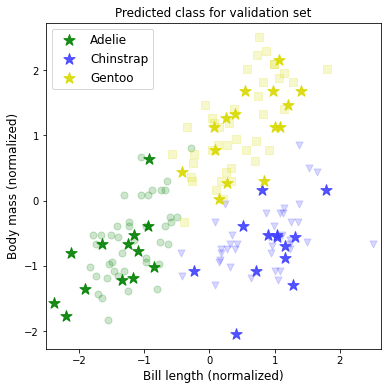

In [37]:
# Try changing the distance function and value of k
distance_fn = euclidean_dist
k = 8

# Plot the predictions using helpers.py
predicted_val_labels = predict(X_val, X_train, y_train, euclidean_dist, k=5)
helpers.plot_predictions(samples=X_val, predicted_labels=predicted_val_labels, X=X_train, y=y_train, 
                         label_map=label_map, feature_names=feature_names, 
                         title="Predicted class for validation set")

## 5. Selecting hyper-parameters

Now is the time to select hyper-parameters. For kNN, the two parameters we can select is the distance function and the number of neighbors k.

First, we need a metric to measure how well our model is doing. 

Here, we'll use the accuracy, defined as:
$$ \text{accuracy} = \frac{\text{# correct predictions}}{\text{# all predictions}}$$

Let's implement this function:

In [38]:
def accuracy(labels_gt: np.ndarray, labels_pred: np.ndarray):
    """ Computes accuracy.
    
    Args:
        labels_gt: labels (ground-truth) of shape (M, ).
        labels_pred: Predicted labels of shape (M, ).
        
    Returns:
        float: Accuracy, in range [0, 1].
    """
    ### START CODE HERE ### (≈ 1 line of code)
    acc = np.sum(labels_gt ==labels_pred)/labels_gt.shape[0]
    ### END CODE HERE ###
    return acc

Now, let's compute the accuracy for both distance functions at all values of k. We can only afford to do that because our dataset is relatively small, so this exhaustive search isn't too computationally expensive.

In [41]:
k_values = []
euclidean_accs = []
manhattan_accs = []
for i in range(1, len(X_train) + 1):
    ### START CODE HERE ### (≈ 2 lines of code)
    manhattan_acc = accuracy(y_val, predict(X_val, distance_fn=manhattan_dist, k=i))
    euclidean_acc = accuracy(y_val, predict(X_val, distance_fn=euclidean_dist, k=i))
    ### END CODE HERE ###
    k_values.append(i)
    manhattan_accs.append(manhattan_acc)
    euclidean_accs.append(euclidean_acc)


[72]
[76]
[58]
[46]
[113]
[30]
[65]
[92]
[58]
[89]
[118]
[54]
[30]
[46]
[106]
[49]
[96]
[57]
[40]
[0]
[103]
[70]
[78]
[7]
[74]
[51]
[30]
[118]
[86]
[103]
[60]
[93]
[119]
[21]
[14]
[94]
[4]
[59]
[6]
[121]
[109]
[72]
[76]
[58]
[46]
[113]
[30]
[65]
[92]
[58]
[89]
[118]
[54]
[30]
[46]
[106]
[49]
[96]
[57]
[40]
[0]
[103]
[70]
[78]
[7]
[74]
[51]
[30]
[118]
[86]
[103]
[60]
[93]
[119]
[21]
[14]
[94]
[4]
[59]
[6]
[121]
[109]
[72 21]
[76 28]
[ 58 113]
[46 28]
[113  19]
[30 90]
[65 81]
[92  2]
[58 54]
[89 66]
[118  77]
[54 58]
[30 83]
[46 42]
[106  59]
[ 49 121]
[ 96 105]
[57  8]
[ 40 115]
[  0 110]
[103  60]
[70 73]
[78 12]
[ 7 97]
[ 74 102]
[51 89]
[30 90]
[118  91]
[86 84]
[103  60]
[60 45]
[93 96]
[119  87]
[21 79]
[ 14 118]
[94 74]
[  4 120]
[ 59 106]
[ 6 31]
[121 112]
[109  42]
[72 21]
[76 28]
[ 58 113]
[46 28]
[113  19]
[30 90]
[65 81]
[92  2]
[58 54]
[89 66]
[118  77]
[54 58]
[30 83]
[46 42]
[106  59]
[ 49 121]
[ 96 105]
[57  8]
[ 40 115]
[  0 110]
[103  60]
[70 73]
[78 12]
[ 7 97]
[ 74 1

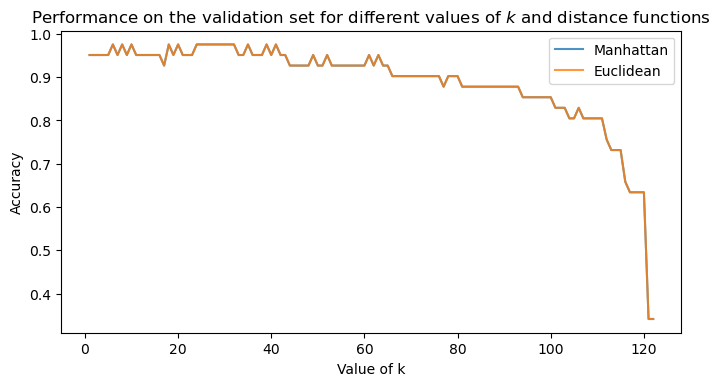

In [42]:
# Plot accuracies
plt.figure(figsize=(8,4), dpi=100)
plt.plot(k_values, manhattan_accs, label="Manhattan", alpha=0.8)
plt.plot(k_values, euclidean_accs, label="Euclidean", alpha=0.8)
plt.xlabel("Value of k")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Performance on the validation set for different values of $k$ and distance functions")
plt.show()

**Question:** What do you notice at the highest value of k? How can this be explained?

**Answer:** YOUR ANSWER HERE

The classifier seems to perform well for both distance metrics and for values of k ranging from 1 to 50, but it is hard to pinpoint which value of k is optimal, and which distance metric is better. This is why, for small datasets, it is often preferred to use [K-Fold Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation) instead of just a single validation set, as it provides more accurate results and is less sensitive to noise. You will see how to implement cross-validation later in this course. For now, just select a value of k and a distance metric that provides good result.

In [43]:
# Choose a good value of k and a good distance metric
k = 25
distance_fn = euclidean_dist

Now that we selected  good hyperparameters, it is time to check how well our model performs on the test set.

In [44]:
# Compute the test accuracy
### START CODE HERE ### (≈ 1 line of code)
test_accuracy = accuracy(y_test, predict(X_test, distance_fn=distance_fn, k=k))
### END CODE HERE ###
print(f"Test accuracy: {test_accuracy * 100: .2f}%")

[ 78  12  69  19 105  11  96  13 113   9  93  58  54  26 106  59 111  20
  85   7  97  56  39  41 114]
[ 89  45  60  22  80 103  66   3  27   6  82  31  76  62  28  29  46  75
   2  10  52  92  32  35  17]
[ 71  36  38  70   7  73  85  97  61 110 111  15  59  56  57   8 106 104
  37  87 114  99 119   0  50]
[ 61  57  38   8  71 110  70  99  73  87  50 104  44  36  37  18  15 119
  92  43  97   7   2  85   0]
[ 90  30  47 102  94  83 108 107  74  64  23  49  77 117  81 121  14  88
  65  48 112 118  95  98  91]
[ 65  14  81  63  67  84  86 118 117 120   4  74  77  25   5  91 100  94
   1  88 102 108  53  23  64]
[ 68  34  24  35 116  52  75  29  72  31   6  84  21  32  86 100  67  82
   3  60   2  79   1  65  25]
[  4 118  63  91  53 120  14  67  81  88  25  77  98   5  65  48   1  84
 101  33  74 100  23 112  16]
[ 93  96  54 105 106  58  13  19  12  78 113  59  11  20  69  56  97   7
  85 111  41 114  15   9  39]
[110   0  99  71  61  18  44  38  43  57   8 101  36  33  70  16  73   5


## 6. Final results

It's finally time to use our newly built classifier to assign classes to the unlabeled data.

In [45]:
# Predict classes of unlabeled data
### START CODE HERE ### (≈ 1 line of code)
predicted_labels = predict(X_unlabeled, distance_fn=distance_fn, k=k)
### END CODE HERE ###


[ 68  34 116  24  35  52  29  75  31  72   6  21  32  86  84  82   3  60
  79 100 109  42  67   2  45]
[  6  31  89  60  75  29  45  52   2   3  32  35 103  82  22  92  24  80
  66  68 116  27  76  34  28]
[ 10  40  62 115  27  66  80  22  17  76 103  45  28  89  46  39  60   3
  55  41  82  51  42  79  20]
[ 21  82  29 116  31  79   3  52  75  42  60 109  24  68  34   6  35 103
  46  28  45  72  76  89  32]
[ 32   2  92   6  50  75  35  52  31 100  29  87  24 119   1  68  34   8
 104  89  25   5  57 116  37]
[109  21  79  42  82   3 116  46  28  29  60  72  31  76  34  68 103  52
  24  75  35  17  45   6  27]
[115  10  66  40  80  22  41  39  89  51  27  62  45  20 114 103 119  37
  76  60 104  28  17  87   2]
[ 31  29  60   3  82   6  75  52  45 103  35 116  24  21  89  68  79  34
  28  76  46  42  22  32  80]
[ 60 103  45   3  76  82  28  46  27  22  89  80  62  66  17  79  42  31
  29   6  10  75 109  52  21]
[ 89  22  66  80 119  45   2  92  51  87  60  37 104  27  50  10 103   6


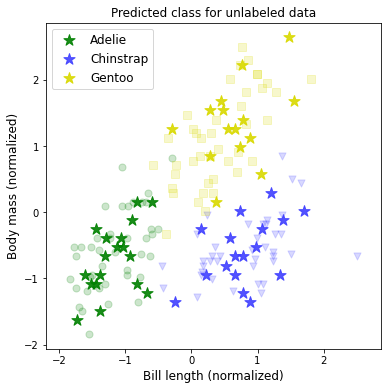

In [46]:
# Plot predictions
helpers.plot_predictions(samples=X_unlabeled, predicted_labels=predicted_labels, X=X_train, y=y_train, 
                         label_map=label_map, feature_names=feature_names, 
                         title="Predicted class for unlabeled data")

**Question:** What are your thoughts on this class assignment? Do these results look reasonable?

**Answer:** YOUR ANSWER HERE

Good job on completing this exercise!